# Environment Setup and Loading Required Data

In [7]:
# To run this code, you should have the data (genome sequence and confidences) in the same folder as this file.

from google.colab import drive
drive.mount('/content/drive')

# Update this if using a different file structure
%cd '/content/drive/MyDrive/ProbaBLAST'

import json
import math
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ProbaBLAST


In [9]:
# load the library sequence and confidence values
# Data is a portion (~600 kilobases) of the predicted chromosome 22 of an ancestral Boreoeutherian (a sub-type of placental mammals)

with open('sequence.txt') as f1:
    library_seq = f1.readline().upper()

with open('confidence.txt') as f2:
    conf = f2.readline().split()
    conf = np.asarray([float(x) for x in conf])
    conf_comp = (1 - conf)/3      # (comp --> complement). The probability for each of the non-predicted nucleotides. Assumes equal probabilities for each.

# Helper Functions

In [10]:
# randomly mutates the given nucleotide (nuc) into another nucleotide (all with equal probability)
# used when testing the algorithm

def mutate(nuc, conf_level, added_mut_chance=0, rng=None):
    if rng is None:
        rng = np.random.RandomState()
    nucleotides = ['A', 'C', 'G', 'T']
    nucleotides.remove(nuc)
    if rng.rand() + added_mut_chance > conf_level:
        return nucleotides[rng.randint(len(nucleotides))]
    else:
        return nuc

In [11]:
def add_to_word_list(lib, word, entry):
    if word in lib:
        lib[word].append(entry)
    else:
        lib[word] = [entry]

In [12]:
# Finds interesting stats about the probabilites in the dataset for a given word size
# returns (mean, std_dev, min, max, %of_words_below_p) of the probabilities of words

def word_stats(sequence, confidence, w, p=0.70):
    min_prob = 1
    max_prob = 0
    num_below_p = 0
    all_probs = []
    for i in range(0, len(sequence) - w + 1):
        new_prob = np.prod(confidence[i: i + w])
        if new_prob < min_prob:
            min_prob = new_prob
        if new_prob > max_prob:
            max_prob = new_prob
        if new_prob < p:
            num_below_p += 1
        all_probs.append(new_prob)
    mean = np.average(all_probs)
    stddev = np.std(all_probs)
    percent_below_p = num_below_p/len(all_probs)
    return mean, stddev, min_prob, max_prob, percent_below_p

# print(word_stats(library_seq, conf, 7, p=0.7))

In [13]:
def print_alignment(seq1, seq2, header=None, line_len=80):
    if header is not None:
        print('Alingment of query segment', header[1], 'and library segment', header[2], 'with score =', '{:.3f}'.format(header[0]))
    for chunk in range(0, math.ceil(len(seq1) / line_len)):
        chunk_start = chunk * line_len
        chunk_end = min(len(seq1), (chunk + 1) * line_len)
        print('query:\t\t', seq1[chunk_start:chunk_end], chunk_end)
        match_string = ''
        for i in range(chunk_start, chunk_end):
            if seq1[i] == seq2[i]:
                match_string = match_string + '|'
            else:
                match_string = match_string + ' '
        print('\t\t', match_string)
        print('library:\t', seq2[chunk_start:chunk_end], chunk_end)
        print()
    print()
    

In [14]:
# I use "coverage" to determine the quality of an alignment
# It measures what proportion of the true range (i.e., the one used to generate the query) overlaps with the one found by probaBLAST.
def coverage(true_range, algn_range):
    true_start, true_stop = true_range
    algn_start, algn_stop = algn_range
    prefix_error = abs(true_start - algn_start)
    suffix_error = abs(true_stop - algn_stop)
    overlap = max(0, (min(true_stop, algn_stop) - max(true_start, algn_start)))
    cov = overlap/(prefix_error + suffix_error + overlap)
    return cov


# Build the Sequence Library

Outputs a JSON library of all the words from the library sequence with length "w" and a probability above "p"

Some potentially useful stats:
*   Sequence Length: 604466 base-pairs
*   Average confidence: 0.927
*   Conf standard deviation: 0.1346
*   Minimum confidence: 0.39


In [19]:
def build_library(sequence, confidence, w, p=0.8):
    lib = {}
    for i in range(0, len(sequence) - w + 1):
        word = sequence[i : i+w]
        conf = np.prod(
            confidence[i : i+w]
        )
        if conf > p:
            add_to_word_list(lib, word, i)
    return lib

In [20]:
def save_library(lib, file_path, indent=0):
    with open(file_path, 'w') as f:
        json.dump(lib, f, indent=indent)

In [21]:
def load_library(file_path):
    with open(file_path) as f:
        return json.load(f)

In [22]:
'''Run this if you don't already have a library saved as a file!'''

lib = build_library(library_seq, conf, 7)
save_library(lib, 'test_lib_w7.json', indent=4)

# ProbaBLAST Algorithm

In [23]:
# coefficient for matches
# conf[i] - (1 - conf[i])/3
# = (4/3)conf[i] - (1/3)
# Equals 1 at conf[i] = 1, 0 at conf[i] = 0.25 (i.e., confidence is no better than random)
# Can also raise the above to a power to change the shape of the curve without affecting its important properties

# Alternative coefficient (inspired by entropy)
# 1 - log4 (conf[i])

In [24]:
def score_coeff(conf):
    return ((4/3) * conf)-(1/3)


def score_word(query, lib_seq, conf):
    out = 0
    for i in range(0, len(query)):
        out += score_coeff(conf[i]) * score(query[i], lib_seq[i])
    return out


# scores a nucleotide pair
def score(n1, n2, match=1, mismatch=-2):
    if n1 != n2:
        return mismatch
    else:
        return match


# Searches the library/database to find indices of all the words in the query sequence.
# filters out library matches that are overlapping to save computation time
def search_lib(query, lib, w):
    matches = []
    for i in range(0, len(query) - w + 1):
        word = query[i:i+w]
        if word in lib:
            matches.append((i, lib[word]))      # a tuple of (index of word in query, [indices of word in database])
    return matches


def ungapped_extension(query, lib_seq, conf, lib_i, q_i, step, D=10):
    best_i = (q_i - step, lib_i - step)   # the indices of the max score in the query and library sequence
    cur_score = 0
    max_score = 0
    while (
        (0 <= q_i < len(query)) and             # ensure indices are in bounds
        (0 <= lib_i < len(lib_seq)) and         # ensure indices are in bounds
        (max_score - cur_score < D)             # stop extension if score drops too far below the maximum
        ):
            cur_score += score_coeff(conf[lib_i]) * score(lib_seq[lib_i], query[q_i])
            if cur_score > max_score:
                max_score = cur_score
                best_i = (q_i, lib_i)
            q_i += step
            lib_i += step
    return max_score, best_i
        

# A version of the Needleman-Wunsch algorithm that accounts for confidence, for gapped extension
def needleman_wunsch(S, T, T_conf, gap=-2):
    S = '-' + S
    T = '-' + T
    T_conf = np.concatenate(([0], T_conf))

    best_index = (0, 0)
    best_score = 0
    
    # Initialization: M is scoring matrix, trace is trace-back matrix
    M = np.full((len(S), len(T)), -float('inf'))
    trace = np.empty((len(S), len(T)), dtype=object)
    for i in range(0, len(S)):
        M[i, 0] = i * gap
        trace[i, 0] = (i-1, 0)
    for j in range(0, len(T)):
        M[0, j] = j * gap
        trace[0, j] = (0, j-1)
    
    # Performing NW algorithm
    for i in range(1, len(S)):
        for j in range(1, len(T)):
            score_match = M[i-1, j-1] + (score_coeff(T_conf[j]) * score(S[i], T[j]))
            score_T_gap = M[i-1, j] + gap
            score_S_gap = M[i, j-1] + gap
            max_score = max(score_match, score_T_gap, score_S_gap)
            M[i, j] = max_score
            if max_score >= best_score:
                best_score = max_score
                best_index = (i, j)

            if score_match == max_score:
                trace[i, j] = (i-1, j-1)
            elif score_T_gap == max_score:
                trace[i, j] = (i-1, j)
            elif score_S_gap == max_score:
                trace[i, j] = (i, j-1)

    # Trace back and return the aligned sequence
    i, j = best_index
    S_str = ''
    T_str = ''
    while i > 0 or j > 0:
        from_i, from_j = trace[i, j]
        if i - from_i == 1:
            if j - from_j == 1:
                S_str = S[i] + S_str
                T_str = T[j] + T_str
            else:
                T_str = '-' + T_str
                S_str = S[i] + S_str
        else:
            S_str = '-' + S_str
            T_str = T[j] + T_str
        i, j = trace[i, j]
    return best_score, (S_str, T_str)

In [25]:
def ProbaBLAST(query, lib_seq, lib, conf, w=7, get_top=5, fit_threshold=0.25, gap=-2, verbose=False):
    start_time = time.time()
    query = query.upper()
    matches = search_lib(query, lib, w)
    
    lib_time = time.time()
    if verbose:
        print('Searching database completed in ', lib_time - start_time, 'seconds')
    
    all_scores = []
    for q_i, indices in matches:
        for lib_i in indices:
            score_init = score_word(query[q_i:q_i + w], lib_seq[lib_i:lib_i + w], conf[lib_i:lib_i + w])
            
            score_L, l_i = ungapped_extension(query, lib_seq, conf, lib_i - 1, q_i - 1, -1)     # Search left of the word
            score_R, r_i = ungapped_extension(query, lib_seq, conf, lib_i + w, q_i + w, 1)      # Search right of the word
            score_tot = (score_init + score_R + score_L)
            query_indices = (l_i[0], r_i[0])
            library_indices = (l_i[1], r_i[1])
            all_scores.append((score_tot, query_indices, library_indices))
    ug_time = time.time()
    if verbose:
        print('Ungapped extension completed in ', ug_time - lib_time, 'seconds')
    
    all_scores = sorted(all_scores, key=lambda x: (x[1][0], x[2][0]))                           # sort by the indices used, so repeated entries (generated from nearby words) can be removed
    
    # remove repeated entries to save computation
    temp = [all_scores[0]]
    i = 1
    while i < len(all_scores):
        if (all_scores[i][1] != temp[-1][1] or all_scores[i][2] != temp[-1][2]):
            temp.append(all_scores[i])
        i += 1
    
    all_scores = sorted(temp, key=lambda x: x[0], reverse=True)                                 # sort by scores descending, so we only need to look at the best ones

    threshold = 15                              # Arbitary threshold that an HSP must be above to consider for gapped extension
    outputs = []
    for entry in all_scores:
        if entry[0] >= threshold:
            
            hsp_start, hsp_stop = entry[1]      # start and end indices of the HSP in the query
            lib_start, lib_stop = entry[2]      # start and end indices of the HSP in the library

            # if the current segment is enclosed by one on which needleman-wunsch was performed, skip it to save computation
            # This can result in some alignments being *slightly* suboptimal
            # (from my testing it did not significantly change the indices aligned, just occasionally changed which residues were matched/where gaps were inserted)
            enclosed_hsp = False
            for previous_nw in outputs:
                if previous_nw[1][0] <= hsp_start and hsp_stop <= previous_nw[1][1]:
                    enclosed_hsp = True
            if enclosed_hsp:
                continue

            # prefix of query must be reversed to work l with needleman wunsch implementation
            query_prefix = query[0:hsp_start][::-1]
            
            # searches for up to (1.5x + 5) times the length of the query segment to ensure the best match is found. This is arbitrary and may be somewhat computationally wasteful, and could surely be improved.
            # the 5 is needed for cases where the segment being searched is very short
            lib_prefix = lib_seq[ max(0, lib_start - int(1.5*len(query_prefix)) - 5): lib_start][::-1]
            conf_prefix = conf[ max(0, lib_start - int(1.5*len(query_prefix)) - 5): lib_start][::-1]
            pre_score, (pre_query_str, pre_lib_str)  = needleman_wunsch(query_prefix, lib_prefix, conf_prefix, gap=gap)
            
            # re-reverse the strings to return them to the proper order. Size is the length without gaps, used to find the exact query/library indices used in the optimal alignment 
            pre_query_str = pre_query_str[::-1]
            pre_query_size = len(pre_query_str) - pre_query_str.count('-')
            pre_lib_str = pre_lib_str[::-1]
            pre_lib_size = len(pre_lib_str) - pre_lib_str.count('-')
            query_suffix = query[hsp_stop:len(query)]
            
            lib_suffix = lib_seq[lib_stop: lib_stop + min(len(lib_seq), int(1.5 * len(query_suffix))) + 5]
            conf_suffix = conf[lib_stop: lib_stop + min(len(lib_seq), int(1.5 * len(query_suffix))) + 5]
            post_score, (post_query_str, post_lib_str) = needleman_wunsch(query_suffix, lib_suffix, conf_suffix, gap=gap)

            post_query_size = len(post_query_str) - post_query_str.count('-')
            post_lib_size = len(post_lib_str) - post_lib_str.count('-')

            query_aligned_indices = (hsp_start - pre_query_size, hsp_stop + post_query_size)
            lib_aligned_indices = (lib_start - pre_lib_size, lib_stop + post_lib_size)
            
            score_tot = pre_score + entry[0] + post_score

            # string representations of the alignment indicating gaps
            query_aligned = pre_query_str + query[hsp_start:hsp_stop] + post_query_str
            lib_aligned = pre_lib_str + lib_seq[lib_start:lib_stop] + post_lib_str

            # a version that shows the separation between the ungapped and needleman-wunsch portions of the algorithm, useful for debugging
            # query_aligned = pre_query_str + '|' + query[hsp_start:hsp_stop] + '|' + post_query_str
            # lib_aligned = pre_lib_str + '|' + lib_seq[lib_start:lib_stop] + '|' + post_lib_str

            outputs.append((score_tot, query_aligned_indices, lib_aligned_indices, (query_aligned, lib_aligned)))
        else:
            break
    nw_time = time.time()
    if verbose:
        print('Needleman Wunsch extensions completed in ', nw_time - ug_time, 'seconds')

    outputs = sorted(outputs, key=lambda x: x[0], reverse=True)
    # for out in outputs[0:get_top]:
        # print(out[0:3])
        # print('query seq: \t', out[3][0])
        # print('library: \t', out[3][1])
        # print('\n')
    return outputs

# Testing the Algorithm

## Functions to Generate Random Mutated Subsequences
Plus: a way to easily(ish) set a bunch of arguments at once (coming soon)

In [26]:
'''

kwargs = {
    w : 7               # Word length
    S :                 # 
    match : 1           # Nucleotide match score
    mismatch : -2       # Nucleotide mismatch score
    gap : -2            # Gap penalty (current implementation is linear penalty only)
    T :                 # Minumum HSP score during ungapped extension to continue to gapped extension (Threshold)
    D :                 # Score below maximum found so far to stop ungapped extension (Delta - must be positive)
}

'''
pass

In [27]:
# generates a subsequence with a length between min_len and max_len (both inclusive)
def get_subseq_indices(seq, min_len, max_len, rng=None):
    if rng is None:
        rng = np.random.RandomState()
    length = rng.randint(min_len, high=max_len + 1)
    start_pos = rng.randint(0, high=len(seq) - length + 1)
    end_pos = start_pos + length
    return start_pos, end_pos


# attempts to mutate a subsequence at every nucleotide, with the probability of a mutation equal to (1 - confidence level) at that nucleotide
def randomize_subseq(seq, conf, start_pos, end_pos, added_mut_chance=0, rng=None):
    if rng is None:
        rng = np.random.RandomState()
    seq = seq[start_pos : end_pos]
    conf = conf[start_pos : end_pos]
    length = end_pos - start_pos
    lst = []
    for i in range(0, length):
        lst.append(mutate(seq[i], conf[i], added_mut_chance=added_mut_chance, rng=rng))
    output = ''.join(lst)
    return output


# returns a mutated subsequence with length between min_len and max_len (both inclusive), with mutation frequency at each nucleotide inversly proportional to the confidence at that nucleotide
# also returns the indices of the library used to generate the sequence, for testing the accuracy of the alignment.
def get_rand_subseq(seq, conf, min_len, max_len, rng=None, indel_coeff=0.04, avg_indel_len=3, added_mut_chance=0, verbose=False):
    if rng is None:
        rng = np.random.RandomState()
    start_pos, end_pos = get_subseq_indices(seq, min_len, max_len, rng=rng)
    mutated = randomize_subseq(seq, conf, start_pos, end_pos, added_mut_chance=added_mut_chance, rng=rng)
    gapped = gapify(mutated, indel_coeff, rng=rng, avg_length=avg_indel_len)
    if verbose:
        print((start_pos, end_pos))
    return gapped, (start_pos, end_pos)


# generates random nucleotides of a given length (for simulating insertions)
def rand_nucleotides(length, rng=None, p=None):
    if rng is None:
        rng = np.random.RandomState()
    nucleotides = ['A', 'C', 'G', 'T']
    sample = rng.choice(nucleotides, size=length, p=p).tolist()
    return ''.join(sample)


# randomly adds and removes nucleotides from a sequence to simulate insertions and deletions
# 
# InDel mutation chance paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4563830/
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2734402/
def gapify(seq, avg_indel_proportion, rng=None, avg_length=3):
    if avg_indel_proportion <= 0:
        return seq
    if rng is None:
        rng = np.random.RandomState()
    avg_num_indels = (len(seq) * avg_indel_proportion)/avg_length
    num_indels = rng.negative_binomial(avg_num_indels, 0.5)
    insert_or_delete = rng.randint(0, 2, size=num_indels)     # currently, probabilites for insertion and deletion are equal. 0 => insert, 1 => delete
    
    indices = rng.choice(len(seq), size=num_indels, replace=False).tolist()
    indices = [0] + indices
    indices.sort()
    split = [seq[i:j] for i, j in zip(indices, indices[1:] + [None])]

    for i in range(0, num_indels):
        length = rng.poisson(lam=avg_length)                  # length of the indel
        if insert_or_delete[i] == 0:
            # insertion
            split[i+1] = rand_nucleotides(length, rng=rng) + split[i+1]
        else:
            # deletion
            split[i+1] = split[i+1][length:]
    output = ''.join(split)
    return output

## Testing

In [28]:
lib = load_library('test_lib_w7.json')

In [29]:
# test on long sequence (5000 bp). Takes about 2 minutes on Colab, from my testing.

seed = 22329
rng = np.random.RandomState(seed=seed)
query, true_inds = get_rand_subseq(library_seq, conf, 5000, 5001, indel_coeff=0.04, added_mut_chance=0.0, rng=rng, verbose=True)
print(query)
print(library_seq[true_inds[0]:true_inds[1]])
print()
likely_candidates = ProbaBLAST(query, library_seq, lib, conf)

for alignment in likely_candidates:
    header = (alignment[0], alignment[1], alignment[2])
    print_alignment(alignment[3][0], alignment[3][1], header=header)

(327023, 332023)
AGGAGTTTTTTTATGAAGTGACCAAAAGAACAAACAATAAAGAAAAAATAGAAAAAAGGGAAATAAGGGAGATAATCAAAGTGTATGTCCAAACCCTTCGGATGCTCTGGACAAAGGTCTGTGGTCCCATCTTACCTGCGTCAATGGCACACGGGTAATGGTATCGGAAGGAGCAGCCTTTGTTGTAGCAGCCCAAGGTGGCGCCTGCCTCCTGGCAGTGGGAACATTTCTGAAAGGAAGGAAGAACTCAGGCATGTCAGGCTTATCCCAGACTCACCCCTCTCCTCCCGGCCTTCCCTCGACCCCATTGGTTAGACCGCAGCACGTGTCCTTGATCTGTGGTTACAGGAGTCTGTGGTGGCAGGACGGGCTGGTCAATTTCTAACCGCCACTCTCTGACCACACCAGAGGAAGGGATCCACCAACAACGTTTTAGGCCAGGCCTCACAAATGTTCGCAAATAAATCAAAGAACACCACAGCGGGGCGAGAGAATCATTCCCAAGAGTCGTGGTGGACACGCCAGAGGGCGGGGCACCCAGCCCTGCCTCTGGCGTGCCCGCTGTCCACCCACCCTCGCTCGCGCTGCCGGTCATTTTCCTCTTTCATCACCGCTATCTTGAGCTGCCCGCAGATCTTGCCTGTTTATTTCTGCTGTGGAAGTCTGGAGTAGGAGAGCGTAAGATAGTAGAGTTATATATAAACCTTTTAGAATTAAAAGTGGAATTCGGTTTCTAGTTCTTATATTTGTAAGATTTTATTTTTATTTTTGATCTACTTACCCCAAATGCCCAATACAAGTATATTTCCCTTTTCAGAAATATGGGCTCCTGTGTGCAAACGGTATTTTTATACACGAATCCTATTTTAAATGCACTAGGAAACCTGCCATGAATTTCTCGGCTAAGTGAGACATTATTCTGTAATTGAGAGGCTCCTCCTTATATGGTCAGGTTTTCTTAAAGTGGGGCACATCTCTACCAT

In [ ]:
# test, with the runtimes of each phase of the algorithm.

seed = 2370089
rng = np.random.RandomState(seed=seed)
query, true_inds = get_rand_subseq(library_seq, conf, 20, 1000, indel_coeff=0.15, rng=rng, verbose=True)
print('Sequence generated from library location: ', true_inds, '\t\tQuery length: ', len(query))
print(query)
print(library_seq[true_inds[0]:true_inds[1]])
print()
likely_candidates = ProbaBLAST(query, library_seq, lib, conf, verbose=True)

for alignment in likely_candidates:
    score = alignment[0]
    query_inds = alignment[1]
    algn_inds = alignment[2]
    header = (score, query_inds, algn_inds)
    print_alignment(alignment[3][0], alignment[3][1], header=header)
    print('Coverage score:', coverage(true_inds, algn_inds))

(163966, 164790)
Sequence generated from library location:  (163966, 164790) 		Query length:  820
CGACATATTTTTACCTGAATTATTTTCCAAAAATTCAAGTGATCTAAGGAGGCTCAAGTGTCAGTGGGGGGAGCTGTGTTTGGAATGCAGACAGGCAAGCTCTGAGCGAGGCTGCTGCTCCCACGCCACCCTATGGTGCAGTGGGCCCCCCAGGCTCACATAGGGTTACACTGTGCCACTGTGTGCTGCGAGCCACGACAGACACAGCAGGACCAAAAACACGATCATAATCAAAGAACCAGCCCTTACTGAAAGAAGTGTGCAGCCCAGGATTGACGGACCCTGCCTCCTGGGACCCACTCTGGCGGGCCCTCTGGTCTGCTCAAAGCACGGCCGGCATCAAAGGCCTATTTTTCTCGCAGCCTAGCCCATCAGCGGTGAGGCACCAGGCCTAAAAGGCCTCCTCTGAAAAACCCTTTCCATCCCGCCTCTTAATTTTCCCCGGCAACCCTTCAGGGGCTCCCCGTTGCCTGCCAGACAGCCGCACTCAAGATTAACCCCTTAACCCCCCAGACTGAGATCTATTAAAGCATCTAAAAGACGCTTGAGATTTTAAGAAATTAGAGACCTTGCCCCCCGCCCCCCAGTGACTCAACGGTGCGTATCTACAGAAGAGCTGCAGACTTTCGCCTGGAAACCTCTGGCTGTTCTCTGACGGAAGGAAACAGGACCCCGAACCTCCCTGGTACCAGCCCAGCTGTCCCCCCCTCACAATGTCCCCGCTCCGCCTCTGTCCTTTTTTCAAGCTGGAGGCAGCCTCCAGACTTGAGGCTTCACCCAGGTTTCTTGTCTTCCAGCCCCAGAAGGTGCGTCCGGGCAC
CGACATATTTTTACCTGAATTATTTTCCAAAAATTCAAGTGAGGAGGCTCAGAAGTGTCAGTGAGGGGGAAGGGCTGTGTT

...done 10
...done 20
...done 30
...done 40
...done 50
...done 60
...done 70
...done 80
...done 90
average coverage = 0.9563100393352528 with standard deviation = 0.17228058998051554


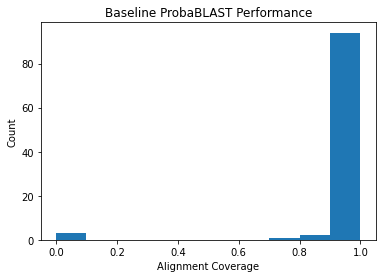

In [ ]:
# Get a baseline accuracy using the default random sequence parameters, based on 100 random sequences
seed = 123456789
rng = np.random.RandomState(seed=seed)
accuracies = []

for i in range(100):
    query, true_inds = get_rand_subseq(library_seq, conf, 50, 500, indel_coeff=0.04, rng=rng, verbose=False)
    likely_candidates = ProbaBLAST(query, library_seq, lib, conf, verbose=False)
    best_cov = 0.0
    for alignment in likely_candidates:
        algn_score = alignment[0]
        algn_inds = alignment[2]
        cov = coverage(true_inds, algn_inds)
        if cov > best_cov:
            best_cov = cov
    accuracies.append(best_cov)
    if i % 10 == 0 and i > 0:
        print('...done', i)

print('average coverage =', np.average(accuracies), 'with standard deviation =', np.std(accuracies))
plt.hist(accuracies)
plt.ylabel('Count')
plt.xlabel('Alignment Coverage')
plt.title('Baseline ProbaBLAST Performance')
plt.show()

In [ ]:
print(sorted(accuracies))
print(np.count_nonzero(np.array(accuracies) == 1.0))

[0.0, 0.0, 0.0, 0.7215189873417721, 0.8235294117647058, 0.8636363636363636, 0.9117647058823529, 0.928395061728395, 0.9411764705882353, 0.9441860465116279, 0.9487179487179487, 0.9637681159420289, 0.9658536585365853, 0.9663157894736842, 0.9705882352941176, 0.9719626168224299, 0.9727272727272728, 0.9759615384615384, 0.9809264305177112, 0.981042654028436, 0.9822485207100592, 0.9823232323232324, 0.9834254143646409, 0.9851851851851852, 0.9864864864864865, 0.9872881355932204, 0.9886363636363636, 0.9895833333333334, 0.9912536443148688, 0.9914529914529915, 0.9919354838709677, 0.9924242424242424, 0.993485342019544, 0.9937888198757764, 0.9938271604938271, 0.9947643979057592, 0.9954128440366973, 0.9954337899543378, 0.9956896551724138, 0.9964664310954063, 0.9970238095238095, 0.9971590909090909, 0.9977876106194691, 0.9978586723768736, 0.9979919678714859, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

[0.0, 0.9639175257731959, 0.9726962457337884, 0.9732142857142857, 0.9819819819819819, 0.9856115107913669, 0.9864864864864865, 0.987012987012987, 0.9872611464968153, 0.9875, 0.9883720930232558, 0.9886363636363636, 0.9900497512437811, 0.9910179640718563, 0.9927007299270073, 0.9936170212765958, 0.9936507936507937, 0.9953488372093023, 0.9961240310077519, 0.9967213114754099, 0.9969230769230769, 0.9971014492753624, 0.9975, 0.9975308641975309, 0.9979338842975206, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
done 0
[0.0, 0.0, 0.8831168831168831, 0.9545454545454546, 0.9598853868194842, 0.9629629629629629, 0.9647577092511013, 0.9657534246575342, 0.9722222222222222, 0.9784

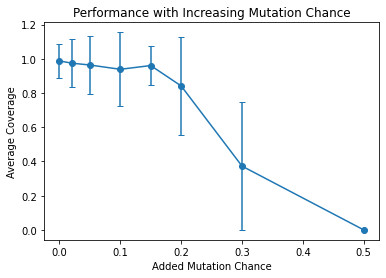

In [ ]:
# Test increasing mutation frequencies (no indels).
# levels = [0, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
levels = [0, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
seed = 123456789
accs_per_level = []
std_devs_per_level = []

for entry in levels:
    rng = np.random.RandomState(seed=seed)
    accuracies = []
    for i in range(100):
        query, true_inds = get_rand_subseq(library_seq, conf, 50, 500, indel_coeff=0.0, added_mut_chance=entry, rng=rng, verbose=False)
        likely_candidates = ProbaBLAST(query, library_seq, lib, conf, verbose=False)
        best_cov = 0.0
        for alignment in likely_candidates:
            algn_score = alignment[0]
            algn_inds = alignment[2]
            cov = coverage(true_inds, algn_inds)
            if cov > best_cov:
                best_cov = cov
        accuracies.append(best_cov)
    accs_per_level.append(np.average(accuracies))
    std_devs_per_level.append(np.std(accuracies))
    print(sorted(accuracies))
    print('done', entry)

plt.errorbar(levels, accs_per_level, yerr=std_devs_per_level, capsize=3.0, fmt='-o')
plt.ylabel('Average Coverage')
plt.xlabel('Added Mutation Chance')
plt.title('Performance with Increasing Mutation Chance')
plt.show()

done 0
done 0.02
done 0.04
done 0.1
done 0.15
done 0.2
done 0.3
done 0.5
done 0.75
done 1


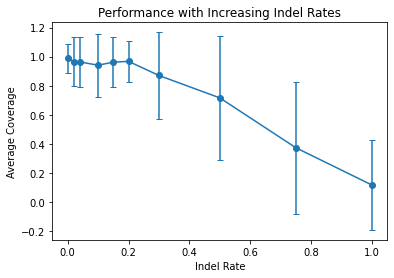

In [ ]:
# Test increasing indel rates
levels = [0, 0.02, 0.04, 0.1, 0.15, 0.2, 0.3, 0.5, 0.75, 1]
seed = 123456789
accs_per_level = []
std_devs_per_level = []

for entry in levels:
    rng = np.random.RandomState(seed=seed)
    accuracies = []
    for i in range(100):
        query, true_inds = get_rand_subseq(library_seq, conf, 50, 500, indel_coeff=entry, rng=rng, verbose=False)
        likely_candidates = ProbaBLAST(query, library_seq, lib, conf, gap=-1, verbose=False)
        best_cov = 0.0
        for alignment in likely_candidates:
            algn_score = alignment[0]
            algn_inds = alignment[2]
            cov = coverage(true_inds, algn_inds)
            if cov > best_cov:
                best_cov = cov
        accuracies.append(best_cov)
    accs_per_level.append(np.average(accuracies))
    std_devs_per_level.append(np.std(accuracies))
    print('done', entry)

plt.errorbar(levels, accs_per_level, yerr=std_devs_per_level, capsize=3.0, fmt='-o')
plt.ylabel('Average Coverage')
plt.xlabel('Indel Rate')
plt.title('Performance with Increasing Indel Rates')
plt.show()

done 2
done 3
done 4
done 5
done 7
done 10
done 15
done 20
done 30


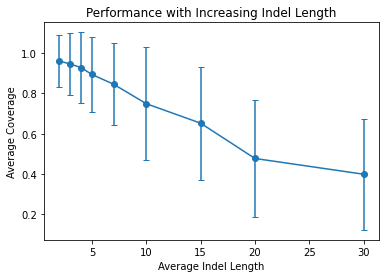

In [ ]:
# Test increasing average indel lengths
levels = [2, 3, 4, 5, 7, 10, 15, 20, 30]
seed = 123456789
accs_per_level = []
std_devs_per_level = []

for entry in levels:
    rng = np.random.RandomState(seed=seed)
    accuracies = []
    for i in range(100):
        query, true_inds = get_rand_subseq(library_seq, conf, 50, 500, avg_indel_len=entry, indel_coeff=0.04*entry, rng=rng, verbose=False)
        likely_candidates = ProbaBLAST(query, library_seq, lib, conf, verbose=False)
        best_cov = 0.0
        for alignment in likely_candidates:
            algn_score = alignment[0]
            algn_inds = alignment[2]
            cov = coverage(true_inds, algn_inds)
            if cov > best_cov:
                best_cov = cov
        accuracies.append(best_cov)
    accs_per_level.append(np.average(accuracies))
    std_devs_per_level.append(np.std(accuracies))
    print('done', entry)

plt.errorbar(levels, accs_per_level, yerr=std_devs_per_level, capsize=3.0, fmt='-o')
plt.ylabel('Average Coverage')
plt.xlabel('Average Indel Length')
plt.title('Performance with Increasing Indel Length')
plt.show()

<function matplotlib.pyplot.show>

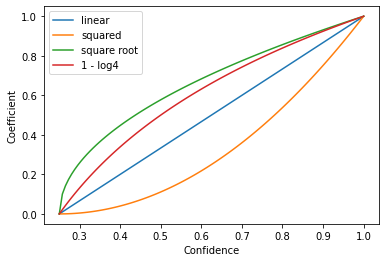

In [ ]:
x = np.linspace(0.25,1, 100)
base_func = (4/3) * x - (1/3)
square = base_func ** 2
root = np.sqrt(base_func)
log4 = 1 + np.log(x)/np.log(4)
plt.plot(x, base_func, label = 'linear')
plt.plot(x, square, label = 'squared')
plt.plot(x, root, label = 'square root')
plt.plot(x, log4, label = '1 - log4')
plt.xlabel('Confidence')
plt.ylabel('Coefficient')
plt.legend()
plt.show